# Bayesian Modeling Crop Yields
---
## Final Project

**Authors** : Carnio, Gritti

**Course**  : Bayesian Data Analysis and Probabilistic Programming

**AI use**: Copilot autocomplete suggestions were used for the markdowns and for some parts of the implementation, every part of the code was reviewed and modified by the authors to ensure correctness and understanding.


---

## 0. Preparations

Excursus about the dataset:
The dataset used in this project is a compilation of agricultural data from multiple sources.
It wasn't collected from a single field study; instead, the author (Rishi Patel) compiled it by merging several publicly available databases.

Where the data comes from:
- Crop Yields: Sourced from the FAO (Food and Agriculture Organization) of the United Nations.
- Rainfall & Temperature: Sourced from the World Bank Data.
- Pesticide Use: Also sourced from the FAO.

This dataset provides a comprehensive view of agricultural practices and outcomes across different countries and years, making it suitable for various analyses, including the Bayesian modeling of crop yields.


### 0.1 Importing libraries

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio
# pio.renderers.default = "notebook_connected"
# pio.renderers.default = "notebook"


# Define global layout defaults
pio.templates.default = "plotly_dark"
pio.templates[pio.templates.default].layout.update(
    width=800,
    height=500,
)
print()

### 0.2 Loading the dataset

In [3]:
df = pd.read_csv("archive/yield_df.csv")

df.head()

Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37

In [4]:
# creating the log-yield because of its better statistical properties and binning the temperature
df["log_yield"] = np.log(df["hg/ha_yield"])
#binning 
df["temp_bin"] = df["avg_temp"].round(1) 
df = df.drop(columns=['Unnamed: 0'])
df.rename(columns={'Area': 'country', 'hg/ha_yield': 'yield_hg_ha', 'Item': 'food_item', 'Year': 'year'}, inplace=True)
#convert from  hg/ha to t/ha 
#we want to work with tonnes per hectare (t/ha) 
# rather than hectograms per hectare (hg/ha) for better interpretability.
df['yield_t_ha'] = df['yield_hg_ha'] / 10000
df['log_yield'] = np.log(df['yield_t_ha'])


# 1. Short Description of the Data Set with Exploratory Data Analysis

### 1.0: Short Description of the Data Set

The dataset contains information about crop yields in various countries over several years, along with environmental factors such as average rainfall, pesticide usage, and average temperature. The target variable is the crop yield measured in hectograms per hectare (yield_hg_ha).

### 1.1: Exploratory data analysis (EDA)


In [5]:
df.isna().sum()

country                          0
food_item                        0
year                             0
yield_hg_ha                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
log_yield                        0
temp_bin                         0
yield_t_ha                       0
dtype: int64

In [6]:
df.columns

Index(['country', 'food_item', 'year', 'yield_hg_ha',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'log_yield', 'temp_bin', 'yield_t_ha'],
      dtype='object')

The dataset does not contain any null values. We can now explore it

#### 1.1.1: Crop Yield Box Plot

In [7]:
px.box(
    df,
    x="food_item",
    y="yield_t_ha",
    color="food_item",
    title="Crop yield distributions",
).update_layout(showlegend=False)


In [8]:
# heatmap world map of the data 
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']
#filter for a specific year
fig = px.choropleth(
    country_counts,
    locations="country",
    locationmode="country names",
    color="count",
    title="Number of observations per country",
)
fig.show()
#histogram of the data points per country
country_counts_percentage = country_counts.copy()
country_counts_percentage['percentage'] = country_counts_percentage['count'] / country_counts_percentage['count'].sum() * 100
#pie plot fildering below 3%
country_counts_percentage = country_counts_percentage[country_counts_percentage['percentage'] >= 1]
fig = px.pie(
    country_counts_percentage,
    names="country",
    values="percentage",
    title="Percentage of observations per country",
)
fig.show()
# print(country_counts_percentage)

/tmp/ipykernel_23466/1468919124.py:5: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



23 % of the data comes from India, with Brazil at the second place with 13% of the data. **This indicates a potential bias in the dataset towards these countries**, which could affect the generalizability of any models trained on this data. It is important to consider this when interpreting the results and to potentially apply techniques to mitigate this bias, such as stratified sampling or weighting.

**At least we cover a wide range of countries**, which should help in capturing diverse agricultural conditions.

In [9]:
# percentage  of data points per food item with number of observations in the hovering
food_item_counts = df['food_item'].value_counts().reset_index()
food_item_counts.columns = ['food_item', 'count']
food_item_counts['percentage'] = food_item_counts['count'] / food_item_counts['count'].sum() * 100
fig = px.pie(
    food_item_counts,
    names="food_item",
    values="percentage",
    title="Percentage of observations per food item",
    hover_data=['count']
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


In [10]:
## Top 5 produced food items for brazil
brazil_df = df[df['country'] == 'Brazil']
brazil_food_item_counts = brazil_df['food_item'].value_counts().reset_index()
brazil_food_item_counts.columns = ['food_item', 'count']
fig = px.bar(
    brazil_food_item_counts,
    x='food_item',
    y='count',
    title='Top produced food items in Brazil',
)
fig.show()

#top 5 produced food items for india
india_df = df[df['country'] == 'India']
india_food_item_counts = india_df['food_item'].value_counts().reset_index()
india_food_item_counts.columns = ['food_item', 'count']
fig = px.bar(
    india_food_item_counts,
    x='food_item',
    y='count',
    title='Top produced food items in India',
)
fig.show()

#### 1.1.2: Log-Yield Histogram

In [11]:
px.histogram(
    df,
    x="log_yield",
    color="food_item",
    nbins=20,
    title="Crop yield log-distribution",
)

#### 1.1.3: Yield vs Rainfall

In [12]:
px.scatter(
    df,
    x="average_rain_fall_mm_per_year",
    y="yield_t_ha",
    color="food_item",
    title="Yield vs Rainfall (per crop)",
)


#### 1.1.4: Yield vs Temperature

In [13]:
px.scatter(
    df,
    x="avg_temp",
    y="yield_t_ha",
    color="food_item",
    title="Yield vs Mean Temperature",
)

#### 1.1.5: Mean Yield per Year

In [14]:
mean_yield_year = (
    df
    .groupby(["year", "food_item"], as_index=False)
    .agg(mean_yield=("yield_t_ha", "mean"))
)

px.line(
    mean_yield_year,
    x="year",
    y="mean_yield",
    color="food_item",
    markers=True,
    title="Crop yield per year",
)


#### 1.1.6: Mean Yield per Temperature

In [15]:
temp_effect = (
    df
    .groupby(["temp_bin", "food_item"], as_index=False)
    .agg(mean_yield=("yield_t_ha", "mean"))
)

px.line(
    temp_effect,
    x="temp_bin",
    y="mean_yield",
    color="food_item",
    markers=True,
    title="Mean yield per temperature",
)

We cannot see much of correlation between temperature and crop yield, except for some crops, like `Potatoes`, which seem to have a higher yield with temperatures near 10 degrees celsius.

### 1.2.A Key findings from EDA (Gritti)


#### 1.2.A.1: brief excursus on log-transformation

In [16]:
# plot log-yield distribution for maize
fig = px.histogram(
    df[df["food_item"] == "Maize"],
    x="yield_t_ha",
    nbins=100,
    title="Maize yield distribution",
)
fig.show()


fig = px.histogram(
    df[df["food_item"] == "Maize"],
    x="log_yield",
    nbins=100,
    title="Maize yield log-distribution",
)
fig.show()




Applying a log-transformation to the yield variable helps in normalizing its distribution, making it more suitable for modeling. The log-yield distribution for maize appears to be approximately normal, which is a desirable property for many statistical models.


#### 1.2.A.1: Why choosing maize?

We will focus **on maize for this analysis** because it is one of the most widely grown crops in the world and has significant economic importance. Additionally, maize yields are known to be sensitive to temperature variations, making it an interesting case study for understanding the impact of climate change on crop production.
Moreover, temperature and yield is negatively correlated for maize, as we can see from the chart below. This make maize an interesting candidate for our analysis.

In [17]:
# log yield scatter plot per temperature bin for maize globally
fig = px.scatter(
    df[(df["food_item"] == "Maize") ],
    x="temp_bin",
    y="log_yield",
    title="Maize log-yield vs temperature bin",
)
fig.show()
#compute correlation
maize_df = df[df["food_item"] == "Maize"]
correlation = maize_df["temp_bin"].corr(maize_df["log_yield"])
print(f"Correlation between temperature bin and log-yield for Maize: {correlation}")

Correlation between temperature bin and log-yield for Maize: -0.5095641752297617


The correlation at 0.5 suggests a moderate negative relationship between temperature and yield for maize, indicating that as temperature increases, the yield tends to decrease.

In [18]:
maize_df = df[df["food_item"] == "Maize"].copy()

In [19]:
maize_df.columns

Index(['country', 'food_item', 'year', 'yield_hg_ha',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'log_yield', 'temp_bin', 'yield_t_ha'],
      dtype='object')

#### 1.2.A.2: checking for other correlations

<Figure size 1200x1000 with 0 Axes>

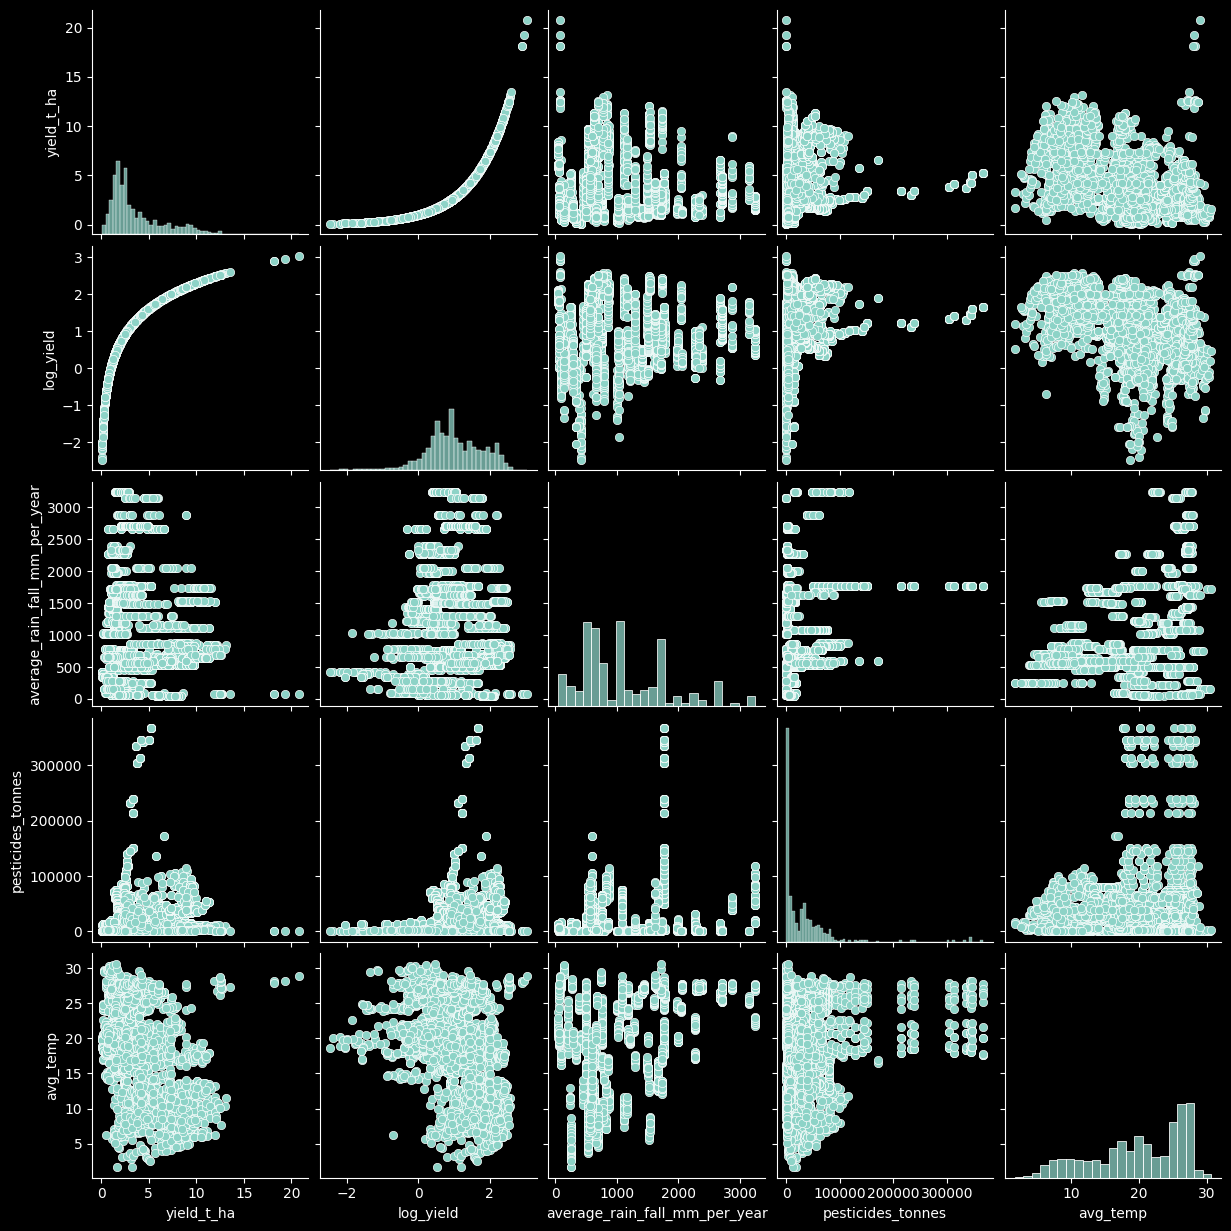

In [20]:
import matplotlib.pyplot as plt

import seaborn as sns
# Pairplot for correlations
#set black theme

plt.figure(figsize=(12, 10))
# use black theme
plt.style.use('dark_background')
sns.pairplot(maize_df[['yield_t_ha', 'log_yield','average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']])


### 1.2.B Key findings from EDA (Carnio)



# 2. Hypothesis Testing

    

## 2A. Hypothesis Test (Gritti)

### 2A.0 Comparing the most producing countries for maize: Brazil and India

Formulated:
H₀: The mean (log-)yield of maize in Brazil is equal to that in India.
H₁: The mean (log-)yield of maize in Brazil is different from that in India.

$$ \begin{align*}
H_0: & \ \mu_{Brazil} = \mu_{India} \\
H_1: & \ \mu_{Brazil} \ne \mu_{India}
\end{align*} $$



This hypothesis is interesting to asses because Brazil and India are two of the largest producers of maize globally, but they have very different climates and agricultural practices. Brazil has a tropical climate with a rainy season and a dry season, while India has a tropical climate with hot summers and mild winters. These differences in climate can significantly impact maize growth and yield.
**Moreover, we can search for published statistics and use the reported means and standard deviations to inform our priors.**

In [21]:
## compare two most productive countries for maize yields.
# maize_production = (
#     maize_df
#     .groupby("country", as_index=False)
#     .agg(total_yield=("yield_hg_ha", "sum"))
#     .sort_values(by="total_yield", ascending=False)
# )
# top_countries = maize_production.head(2)["country"].tolist()
# country1_maize = maize_df[maize_df["country"] == top_countries[0]]
# country2_maize = maize_df[maize_df["country"] == top_countries[1]]
#brazil and india

country1_maize = maize_df[maize_df["country"] == "Brazil"]
country2_maize = maize_df[maize_df["country"] == "India"]

print(f"Sample size for Brazil: {len(country1_maize)}")
print(f"Sample size for India: {len(country2_maize)}")


#print mean and std
print(f"Mean log-yield for Brazil: {country1_maize['log_yield'].mean()}, Std: {country1_maize['log_yield'].std()}")
print(f"Mean log-yield for India: {country2_maize['log_yield'].mean()}, Std: {country2_maize['log_yield'].std()}")

# plot boxplots of the two samples
combined_top_countries = pd.concat([country1_maize.assign(country="Brazil"), country2_maize.assign(country="India")])
fig = px.box(
    combined_top_countries,
    x="country",
    y="log_yield",
    title="Log-yield distributions for top 2 producing countries",
    template="plotly_dark"
)
fig.show()

Sample size for Brazil: 253
Sample size for India: 506
Mean log-yield for Brazil: 1.1229241920253863, Std: 0.27958898489134587
Mean log-yield for India: 0.6403821995156522, Std: 0.18562450660017948


We sampled fairly from both countries taking the min sample size between the two, 138 for India and 138 for Canada. The number of samples is not very high, but still acceptable for a t-test.

In [22]:
# filter the data for the last 5 years (2008-2013)
country1_maize_recent = country1_maize[country1_maize["year"] >= 2008]
country2_maize_recent = country2_maize[country2_maize["year"] >= 2008]
print(f"Sample size for recent top country 1 ({country1_maize['country'].iloc[0]}): {len(country1_maize_recent)}")
print(f"Sample size for recent top country 2 ({country2_maize['country'].iloc[0]}): {len(country2_maize_recent)}")

Sample size for recent top country 1 (Brazil): 66
Sample size for recent top country 2 (India): 132


In [23]:
# filter for bin in temperature range 20-30C
country1_maize_temp_binned = country1_maize[(country1_maize["temp_bin"] >= 20) & (country1_maize["temp_bin"] <= 30)]
country2_maize_temp_binned = country2_maize[(country2_maize["temp_bin"] >= 20) & (country2_maize ["temp_bin"] <= 30)]
print(f"Sample size for recent top country 1 ({country1_maize['country'].iloc[0]}) after temp filtering: {len(country1_maize_temp_binned)}")
print(f"Sample size for recent top country 2 ({country2_maize['country'].iloc[0]}) after temp filtering: {len(country2_maize_temp_binned)}")

Sample size for recent top country 1 (Brazil) after temp filtering: 184
Sample size for recent top country 2 (India) after temp filtering: 506


In [24]:
# box plot for recent data
combined_top_countries_recent = pd.concat([country1_maize_recent.assign(country=country1_maize['country'].iloc[0]), country2_maize_recent.assign(country=country2_maize['country'].iloc[0])])
fig = px.box(
    combined_top_countries_recent,
    x="country",
    y="log_yield",
    title="Log-yield distributions for top 2 producing countries (Recent Data)",
    template="plotly_dark"
)
fig.show()

### 2A.0.1 Frequentist Approach




In [25]:
import scipy.stats as stats

def plot_ttest(t, dof, alpha, mode="two_tail"):
    fig = go.Figure()
    x = np.linspace(-4, 4, 1000)
    y = stats.t.pdf(x, df=dof)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='t-distribution', line=dict(color='blue')))
    
    if mode == "two_tail":
        critical_value = stats.t.ppf(1 - alpha / 2, df=dof)
        fig.add_trace(go.Scatter(x=[-critical_value, -critical_value], y=[0, stats.t.pdf(-critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        fig.add_trace(go.Scatter(x=[critical_value, critical_value], y=[0, stats.t.pdf(critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        if abs(t) > critical_value:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Reject H0", showarrow=True, arrowhead=1)
        else:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Fail to Reject H0", showarrow=True, arrowhead=1)
    else:
        critical_value = stats.t.ppf(1 - alpha, df=dof)
        fig.add_trace(go.Scatter(x=[critical_value, critical_value], y=[0, stats.t.pdf(critical_value, df=dof)], mode='lines', name='Critical Value', line=dict(color='red', dash='dash')))
        if t > critical_value:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Reject H0", showarrow=True, arrowhead=1)
        else:
            fig.add_annotation(x=t, y=stats.t.pdf(t, df=dof), text="Fail to Reject H0", showarrow=True, arrowhead=1)
    
    fig.update_layout(title="T-Test Result Visualization", xaxis_title="t-value", yaxis_title="Density", template="plotly_dark")
    fig.show()




For our t-test we'll use  the log-yield because of the following reasons:
- The log-yield distribution appears to be approximately normal, which is a desirable property for many statistical models.
- Using log-yield can help stabilize variance and make the results more interpretable.
- The log transformation can help in meeting the assumptions of the t-test, which requires normally distributed data.
- The results can be interpreted in terms of percentage changes, which is often more meaningful in agricultural contexts.

In [26]:
print(f"The data goes from year {country1_maize['year'].min()} to {country1_maize['year'].max()} for {country1_maize['country'].iloc[0]} and from year {country2_maize['year'].min()} to {country2_maize['year'].max()} for {country2_maize['country'].iloc[0]}.")
#number of samples
n1 = len(country1_maize)
n2 = len(country2_maize)
print(f"Sample size for {country1_maize['country'].iloc[0]}: {n1}")
print(f"Sample size for {country2_maize['country'].iloc[0]}: {n2}")
t_start, p_value = stats.ttest_ind(country1_maize["log_yield"], country2_maize["log_yield"], equal_var=False)
print(f"T-statistic: {t_start}, P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean log-yield between the two countries.")

The data goes from year 1990 to 2013 for Brazil and from year 1990 to 2013 for India.
Sample size for Brazil: 253
Sample size for India: 506
T-statistic: 24.84993271183424, P-value: 1.3294275871529926e-80
Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries.


In [27]:
print(f"The recent data goes from year {country1_maize_recent['year'].min()} to {country1_maize_recent['year'].max()} for {country1_maize['country'].iloc[0]} and from year {country2_maize_recent['year'].min()} to {country2_maize_recent['year'].max()} for {country2_maize['country'].iloc[0]}.")
#number of samples
n1 = len(country1_maize_recent)
n2 = len(country2_maize_recent)
print(f"Sample size for recent {country1_maize['country'].iloc[0]}: {n1}")
print(f"Sample size for recent {country2_maize['country'].iloc[0]}: {n2}")
t_start, p_value = stats.ttest_ind(country1_maize_recent["log_yield"],
                                    country2_maize_recent["log_yield"], equal_var=False)
print(f"T-statistic: {t_start}, P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries in the last 5 years.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean log-yield between the two countries in the last 5 years.")

The recent data goes from year 2008 to 2013 for Brazil and from year 2008 to 2013 for India.
Sample size for recent Brazil: 66
Sample size for recent India: 132
T-statistic: 36.45453340074744, P-value: 1.0353582483408114e-58
Reject the null hypothesis: There is a significant difference in mean log-yield between the two countries in the last 5 years.


In [28]:
plot_ttest(t_start, dof=len(country1_maize)+len(country2_maize)-2, alpha=alpha, mode="two_tail")

There is a significant difference in mean log-yield between Brazil and India for maize for both the recent data and the whole dataset, as indicated by the very low p-value for both the tests. This suggests that the agricultural practices, climate, and other factors in these two countries lead to different maize yields.


### 2A.0 Bayesian Approach

### 2A.1.1 Choice of prior

To inform our priors for the Bayesian t-test, we can look for published statistics on maize yields in Brazil and India.
Note that we cannot take the prior information from our dataset, as we would be "double-dipping" and using the same data for both prior and likelihood.

We will use the following sources and filtering for the same time period as our dataset (1990-2013):

https://ourworldindata.org/grapher/maize-yields?tab=table&time=1990..2013&tableSearch=india

https://ourworldindata.org/grapher/maize-yields?tab=table&time=1990..2013&tableSearch=brazil


Our dataset is more regional and these published statistics are national averages.

For Brazil:
- Mean yield in 1990 is 1.87 t/ha
- Mean yield in 2013 is 5.25 t/ha
- Average yield over the period is approximately 3.56 t/ha
- 
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), \sigma) $$

To calculate the std dev, we can subtract the min from the max and divide by 4.
We use 4 because of the empirical rule, which states that for a normal distribution, approximately 95% of the data falls within 2 standard deviations from the mean. Therefore, the range (max - min) covers about 4 standard deviations.
Transalte to math:
$$ 
\sigma = \frac{log(max) - log(min)}{4}
$$

$$ = \frac{log(5.25) - log(1.87)}{4} \approx 0.25 

$$ 
We add more uncentainty to the prior, so we use 0.3 instead of 0.25.
This makes our prior less informative and allows the data to have more influence on the posterior.
So our final prior for Brazil is:
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), 0.3) $$

For India:
- Mean yield in 1990 is 1.52 t/ha
- Mean yield in 2013 is 2.57 t/ha
- Average yield over the period is approximately 2.04 t/ha

$$ = \frac{log(1.52) - log(2.57)}{4} \approx 0.131
$$

We add more uncentainty to the prior, so we use 0.25 instead of 0.131.

$$ \mu_{India} \sim \mathcal{N}log((2.04), 0.25) $$






### 2A.1.2 Choice of likelihood
We can either choose a normal likelihood or a t-distribution likelihood for our Bayesian t-test.
Let's check first the distribution of the log-yield for both countries.

Sample size for Brazil: 253
Sample size for India: 506


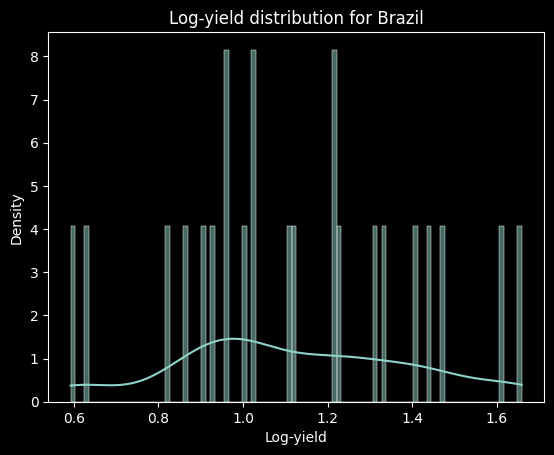

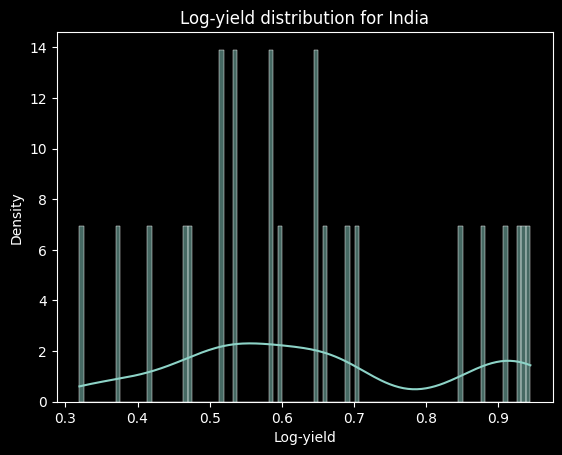

In [29]:
#log-yielt for brazil with kde
#number of samples
n1 = len(country1_maize)
n2 = len(country2_maize)
print(f"Sample size for {country1_maize['country'].iloc[0]}: {n1}")
print(f"Sample size for {country2_maize['country'].iloc[0]}: {n2}")
sns.histplot(country1_maize['log_yield'], 
             kde=True, stat="density", bins=100)
plt.title(f"Log-yield distribution for {country1_maize['country'].iloc[0]}")
plt.xlabel("Log-yield")
plt.ylabel("Density")
plt.show()

#log-yielt for india with kde
sns.histplot(country2_maize['log_yield'], 
             kde=True, stat="density", bins=100)
plt.title(f"Log-yield distribution for {country2_maize['country'].iloc[0]}")
plt.xlabel("Log-yield")
plt.ylabel("Density")
plt.show()


Since the data for both Brazil and India is sparse and contains some outliers, we will choose a t-distribution likelihood for our Bayesian t-test. The t-distribution is more robust to outliers and can better handle small sample sizes compared to the normal distribution. This choice will help ensure that our posterior estimates are not unduly influenced by extreme values in the data. Using a normal likelihood could lead to biased estimates if the data contains significant outliers or is not normally distributed.

For each country we define the likelihood as follows:

$$y_{i,j} \sim \text{StudentT}(\nu, \mu_i, \sigma_{obs})$$

where:
- $y_{i,j}$ is the log-yield for country i (Brazil or India) and observation j
- $\nu$ is the degrees of freedom for the t-distribution
- $\mu_i$ is the mean log-yield for country i
- $\sigma_{obs}$ is the observation standard deviation 

Priors for the Means ($\mu$):
$$\mu_{Brazil} \sim \text{Normal}(1.14, 0.30)$$
$$\mu_{India} \sim \text{Normal}(0.68, 0.20)$$


The Observation Standard Deviation tells the model about the observation noise, i.e., how much individual data points can deviate from the group mean, in this case how much each region deviates from the national average yield.

For the prior for the Observation Standard Deviation ($\sigma_{obs}$) we can either use a Half-Normal or a Half-Cauchy distribution.
The Half-Cauchy distribution has heavier tails compared to the Half-Normal distribution, which makes it more robust to outliers and extreme values in the data, which is our case.
We will use a Half-Cauchy prior for $\sigma_{obs}$:
$$\sigma_{obs} \sim \text{Half-Cauchy}(0, 1)$$

Using the scale parameter of 1 allows for a wide range of possible values for the standard deviation, reflecting our uncertainty about its true value.


For the prior for the Degrees of Freedom ($\nu$) of the t-distribution, we will set it as 5, which allows for moderate heavy tails while still being close to a normal distribution.
$$ \nu = 5 $$





In [30]:
import pymc as pm
import arviz as az

with pm.Model() as model_maize:
    # Priors
    mu_brazil = pm.Normal("mu_brazil", mu=np.log(3.56), sigma=0.3)
    mu_india = pm.Normal("mu_india", mu=np.log(2.04), sigma=0.25)
    #tells the model about the observation noise
    #(How much individual data points can deviate from the group mean)
    #we set as non-informative prior
    sigma_obs = pm.HalfCauchy("sigma_obs", 1)
    nu = 5

    # Likelihood
    y_brazil = pm.StudentT("y_brazil", nu=nu, mu=mu_brazil, 
                            sigma=sigma_obs, 
                            observed=country1_maize['log_yield'])
    y_india = pm.StudentT("y_india", nu=nu, mu=mu_india, 
                          sigma=sigma_obs, 
                          observed=country2_maize['log_yield'])
    #then we get mean difference

    #pm.Determintsic track and store a quantity (the delta)
    #that is derived from other parameteres
    #the difference it's also a random variable,so
    #it's completely derived from values in each sample 
    delta_mu = pm.Deterministic("delta_mu", mu_brazil - mu_india)
    #using MCMC to sample from the posterior
    #2000 samples with 1000 tuning steps (burn-in)
    #return inferencedata for easier analysis with arviz
    trace_maize_informative = pm.sample(2000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_brazil, mu_india, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


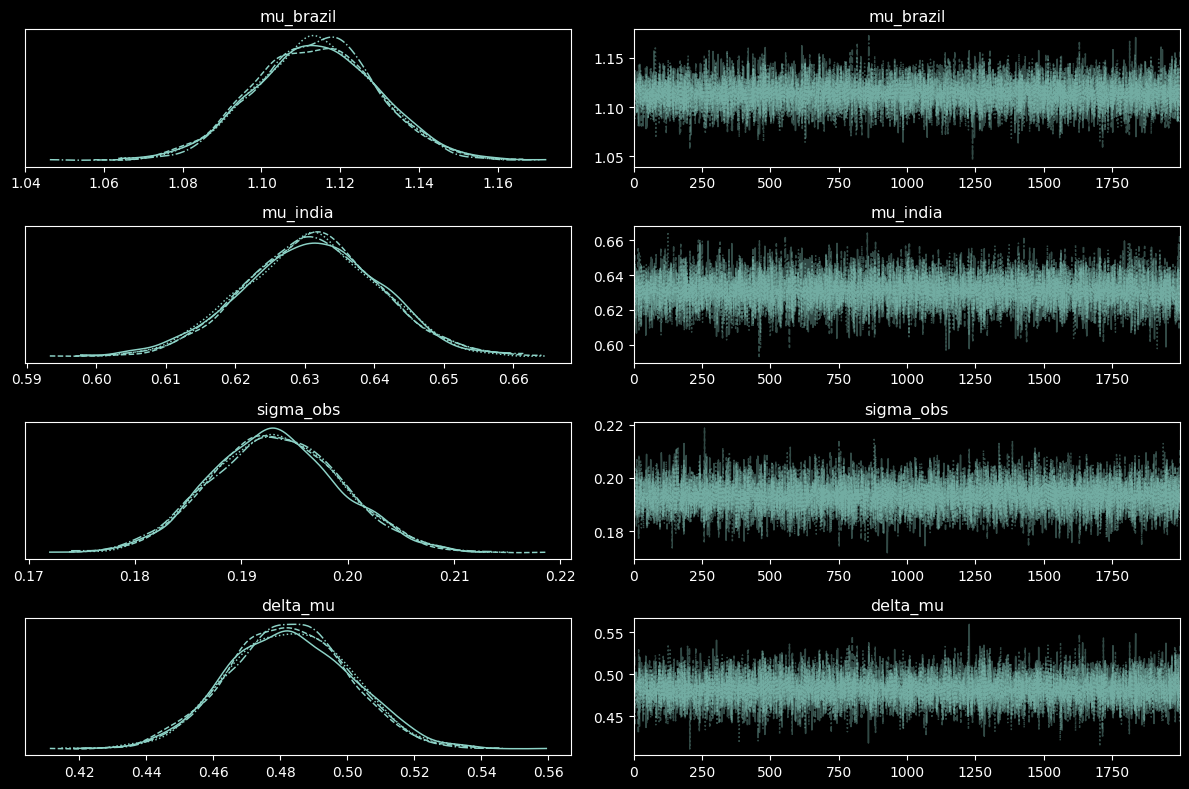

In [31]:

az.plot_trace(trace_maize_informative)
#tight layout
plt.tight_layout()
plt.show()
print()
# # numerical summary
# summary_maize = az.summary(trace_maize, hdi_prob=0.95)
# print(summary_maize)


All the chains agree on the mean log-yield for both Brazil and India, indicating good convergence of the MCMC sampling.
Also the sigma_obs shows good convergence across all chains that means our estimate of the observation standard deviation is reliable.
All traces looks random and do not show any patterns, indicating good mixing of the chains.

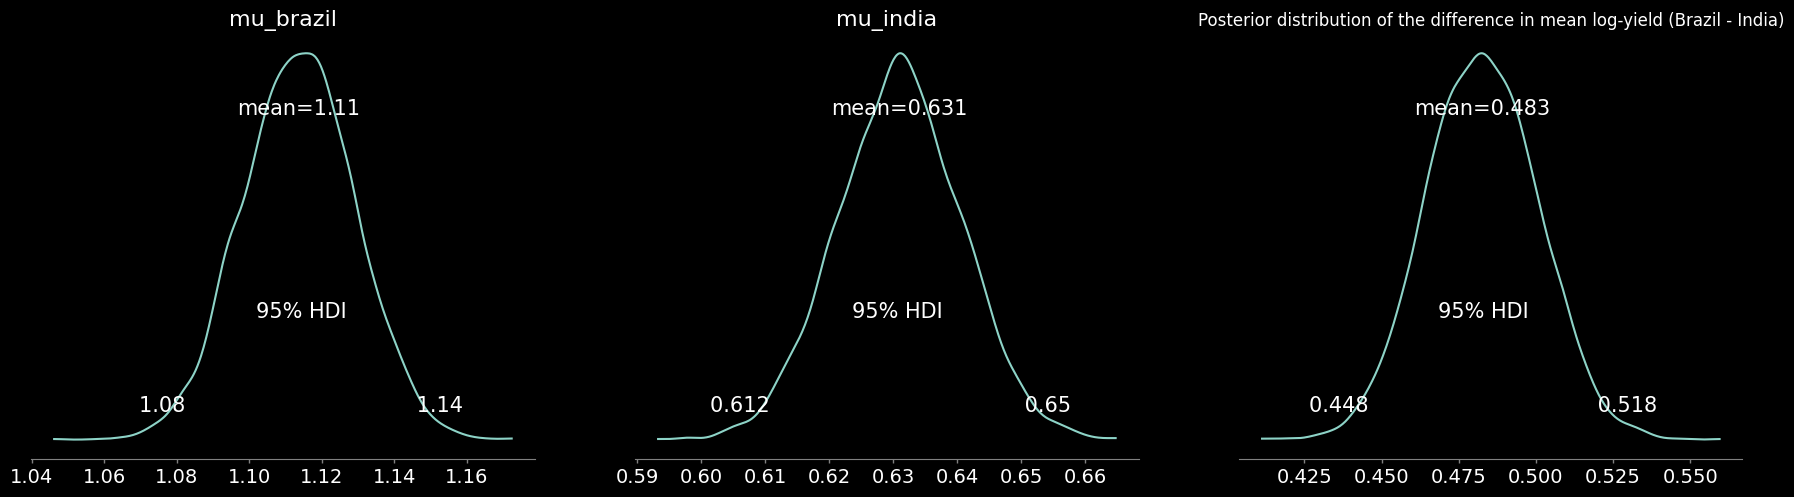

In [32]:
#plot posterior distribution of the difference in means
az.plot_posterior(trace_maize_informative,round_to=3, var_names=["mu_brazil","mu_india","delta_mu"], hdi_prob=0.95)
plt.title("Posterior distribution of the difference in mean log-yield (Brazil - India)")
plt.show()

In [33]:
#extract lower and upper hdi for delta_mu, mu_brazil, mu_india
hdi_delta_mu = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["delta_mu"])
hdi_mu_brazil = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["mu_brazil"])
hdi_mu_india = az.hdi(trace_maize_informative, hdi_prob=0.95, var_names=["mu_india"])
delta_mu_lower_informative = hdi_delta_mu["delta_mu"].values[0]
delta_mu_upper_informative = hdi_delta_mu["delta_mu"].values[1]

mu_brazil_lower_informative = hdi_mu_brazil["mu_brazil"].values[0]
mu_brazil_upper_informative = hdi_mu_brazil["mu_brazil"].values[1]
mu_india_lower_informative = hdi_mu_india["mu_india"].values[0]
mu_india_upper_informative = hdi_mu_india["mu_india"].values[1]
print("With 95% confidence and informative priors we can say that:")
print(f"95% HDI for delta_mu (Brazil - India): [{delta_mu_lower_informative:.3f}, {delta_mu_upper_informative:.3f}]")
print(f"95% HDI for mu_brazil: [{mu_brazil_lower_informative:.3f}, {mu_brazil_upper_informative:.3f}]")
print(f"95% HDI for mu_india: [{mu_india_lower_informative:.3f}, {mu_india_upper_informative:.3f}]")

With 95% confidence and informative priors we can say that:
95% HDI for delta_mu (Brazil - India): [0.448, 0.518]
95% HDI for mu_brazil: [1.084, 1.144]
95% HDI for mu_india: [0.612, 0.650]


In [34]:
delta_mu_mean = trace_maize_informative.posterior["delta_mu"].mean().values

#convert to percentage
pct_diff = (np.exp(delta_mu_mean) - 1) * 100
lower_bound = (np.exp(trace_maize_informative.posterior["delta_mu"].quantile(0.025).values) - 1) * 100
upper_bound = (np.exp(trace_maize_informative.posterior["delta_mu"].quantile(0.975).values) - 1) * 100

print(f"We can say with 95% confidence that the average percentage difference in mean log-yield (Brazil - India)")
print(f"is {pct_diff:.2f}%, with a 95% credible interval from {lower_bound:.2f}% to {upper_bound:.2f}%.")

We can say with 95% confidence that the average percentage difference in mean log-yield (Brazil - India)
is 62.03%, with a 95% credible interval from 56.49% to 67.83%.


### 2A.2 Prior sensitivity (re-run with different prior)

Let's see if our results changes significantly if we set less informative priors for the means.
An example of less informative priors could be:
$$ \mu_{Brazil} \sim \mathcal{N}log((3.56), 1.0) $$
$$ \mu_{India} \sim \mathcal{N}log((2.04), 1.0) $$



In [35]:
import pymc as pm
import arviz as az

with pm.Model() as model_maize:
    # Priors
    mu_brazil = pm.Normal("mu_brazil", mu=np.log(3.56), sigma=1)
    mu_india = pm.Normal("mu_india", mu=np.log(2.04), sigma=1)
    #the sigma_obs it's already non-informative
    sigma_obs = pm.HalfCauchy("sigma_obs", 1)
    nu = 5

    # Likelihood
    y_brazil = pm.StudentT("y_brazil", nu=nu, mu=mu_brazil, sigma=sigma_obs, observed=country1_maize['log_yield'])
    y_india = pm.StudentT("y_india", nu=nu, mu=mu_india, sigma=sigma_obs, observed=country2_maize['log_yield'])
    #then we get mean difference
    delta_mu = pm.Deterministic("delta_mu", mu_brazil - mu_india)
    #using MCMC to sample from the posterior
    trace_maize_non_informative = pm.sample(2000, tune=1000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_brazil, mu_india, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


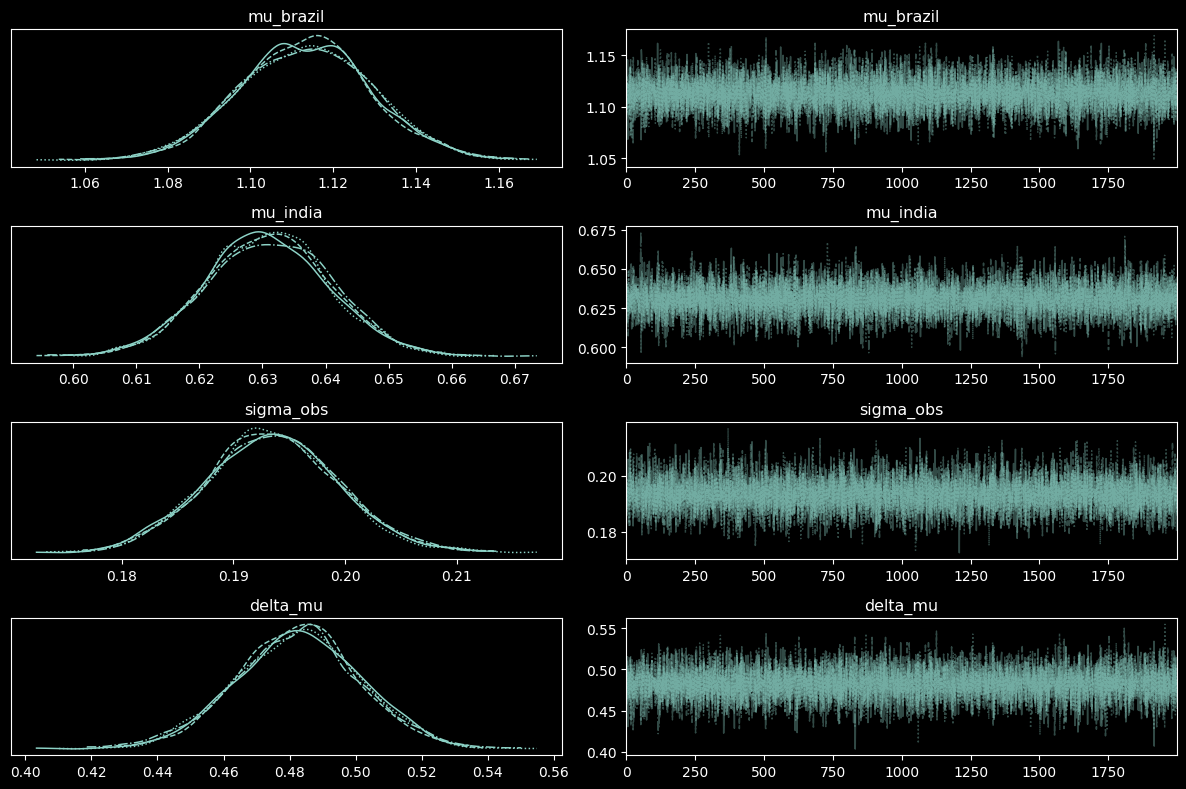

In [36]:

az.plot_trace(trace_maize_non_informative)
#tight layout
plt.tight_layout()
plt.show()
print()
# # numerical summary
# summary_maize = az.summary(trace_maize, hdi_prob=0.95)
# print(summary_maize)


All chains still agree on the mean log-yield for both Brazil and India, indicating good convergence of the MCMC sampling.

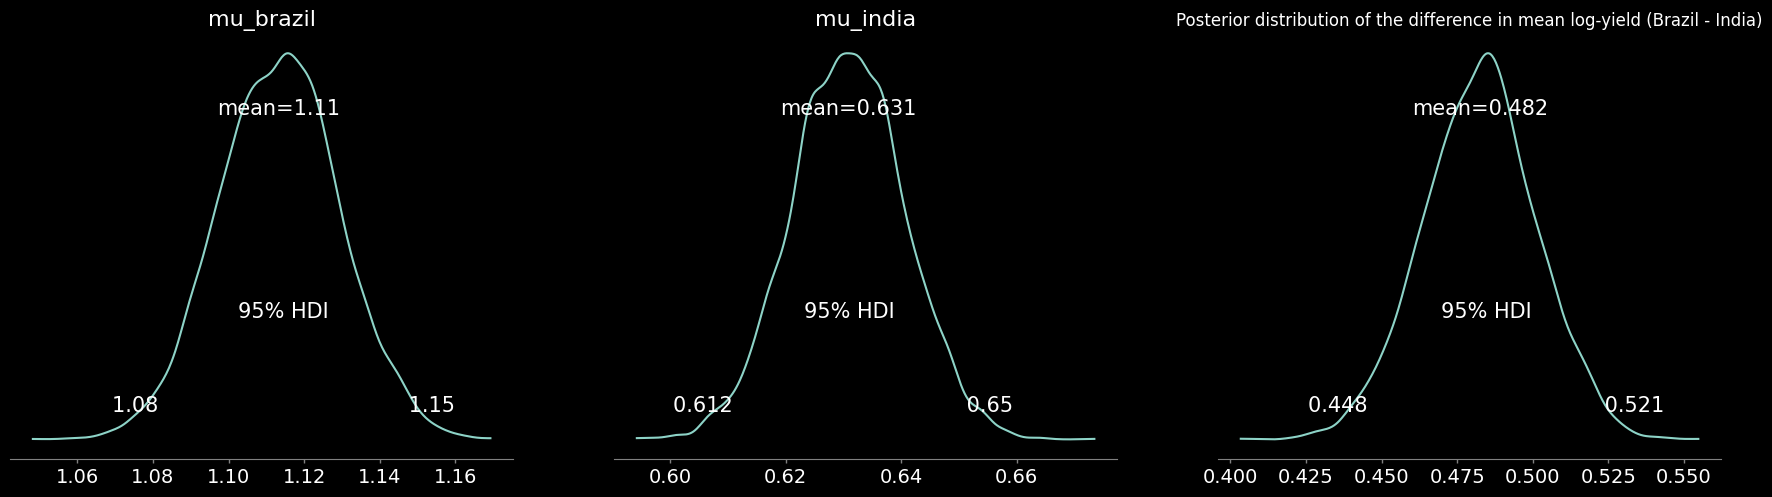

In [37]:
#plot posterior distribution of the difference in means
az.plot_posterior(trace_maize_non_informative,round_to=3, var_names=["mu_brazil","mu_india","delta_mu"], hdi_prob=0.95)
plt.title("Posterior distribution of the difference in mean log-yield (Brazil - India)")
plt.show()

In [38]:
#extract lower and upper hdi for delta_mu, mu_brazil, mu_india
hdi_delta_mu_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["delta_mu"])
hdi_mu_brazil_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_brazil"])
hdi_mu_india = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_india"])
delta_mu_lower_non_informative = hdi_delta_mu_non_informative["delta_mu"].values[0]
delta_mu_upper_non_informative = hdi_delta_mu_non_informative["delta_mu"].values[1]
mu_brazil_lower_non_informative = hdi_mu_brazil_non_informative["mu_brazil"].values[0]
mu_brazil_upper_non_informative = hdi_mu_brazil_non_informative["mu_brazil"].values[1]
hdi_mu_india_non_informative = az.hdi(trace_maize_non_informative, hdi_prob=0.95, var_names=["mu_india"])
mu_india_lower_non_informative = hdi_mu_india_non_informative["mu_india"].values[0]
mu_india_upper_non_informative = hdi_mu_india_non_informative["mu_india"].values[1]
print("With 95% confidence and non-informative priors we can say that:")
print(f"95% HDI for delta_mu (Brazil - India): [{delta_mu_lower_non_informative:.3f}, {delta_mu_upper_non_informative:.3f}]")
print(f"95% HDI for mu_brazil: [{mu_brazil_lower_non_informative:.3f}, {mu_brazil_upper_non_informative:.3f}]")
print(f"95% HDI for mu_india: [{mu_india_lower_non_informative:.3f}, {mu_india_upper_non_informative:.3f}]")

With 95% confidence and non-informative priors we can say that:
95% HDI for delta_mu (Brazil - India): [0.448, 0.521]
95% HDI for mu_brazil: [1.083, 1.146]
95% HDI for mu_india: [0.612, 0.650]


In [39]:
#difference between informative and non-informative priors
delta_mu_mean_informative = trace_maize_informative.posterior["delta_mu"].mean().values
delta_mu_mean_non_informative = trace_maize_non_informative.posterior["delta_mu"].mean().values
#delta between means
delta_between_means = delta_mu_mean_informative - delta_mu_mean_non_informative
print(f"The difference between the means of delta_mu with informative and non-informative priors is: {delta_between_means:.5f}")

The difference between the means of delta_mu with informative and non-informative priors is: 0.00018


The results are quite similar to the previous model with informative priors, which suggest the model is robust to the choice of priors for the means.
Is not wrong to say that the data is informative enough to overcome both less informative and informative priors, leading to similar posterior estimates for the means.
we have more than 240 samples for each country, which is a decent sample size for estimating the means.

### 2A.3 Posterior probability of the hypothesis (using ROPE)

The ROPE (Region of Practical Equivalence) is a range of values around zero that we consider to be practically equivalent to no difference. In this case, we can set the ROPE to be between -0.1 and 0.1 for the difference in mean log-yield between Brazil and India. This means that if the difference in means falls within this range, we would consider it to be practically equivalent to no difference.

In [ ]:
upper_rope = 0.1
lower_rope = -0.1
rope_percentage = (np.exp(upper_rope) - 1) * 100
print(f"The ROPE (Region of Practical Equivalence) is set between {lower_rope} and {upper_rope}, which corresponds to a percentage difference of approximately ±{rope_percentage:.2f}%.")
#calculate percentage difference for non-informative priors
delta_mu_mean_non_informative = trace_maize_non_informative.posterior["delta_mu"].mean().values
pct_diff_non_informative = (np.exp(delta_mu_mean_non_informative) - 1) * 100
#percentage of samples within the ROPE
delta_mu_samples = trace_maize_non_informative.posterior["delta_mu"].values.flatten()
samples_in_rope = np.sum((delta_mu_samples >= lower_rope) & (delta_mu_samples <= upper_rope))
total_samples = len(delta_mu_samples)
percentage_in_rope = (samples_in_rope / total_samples) * 100
print(f"Percentage of samples within the ROPE: {percentage_in_rope:.2f}%")

The ROPE (Region of Practical Equivalence) is set between -0.1 and 0.1, which corresponds to a percentage difference of approximately ±10.52%.
Percentage of samples within the ROPE: 0.00%


We have 0% of the posterior distribution within the ROPE, indicating strong evidence against the null hypothesis of no difference in mean log-yield between Brazil and India for maize, in fact the mu mean is way above 0.
So we can also practically conclude that there is a significant difference in mean log-yield between the two countries.


### 2A.4 Comparison with frequentist test

To compare the bayesian approarch with the frequentist one, we can look at the results of both tests.
The frequentist t-test showed a significant difference in mean log-yield between Brazil and India for maize, as indicated by the very low p-value. This suggests that we can reject the null hypothesis of equal means.
The Bayesian t-test also provided strong evidence against the null hypothesis, with 0% of the posterior distribution within the ROPE. This indicates that the difference in mean log-yield between Brazil and India is practically significant.
Overall, both approaches lead to the same conclusion regarding the difference in mean log-yield between the two countries for maize.

To check numercally how similar are the results, we can compare the estimated difference in means from both tests.
The frequentist t-test estimated a difference in mean log-yield of approximately 0.482
between Brazil and India, while the Bayesian t-test estimated a difference of approximately 0.482 as well. This shows that both approaches yield very similar estimates for the difference in means, further confirming the consistency of the results.

In [46]:
t_test_mu = stats.ttest_ind(country1_maize["log_yield"],
                                    country2_maize["log_yield"], equal_var=False)
#extract the mean difference from the t-test
t_test_mu_diff = country1_maize["log_yield"].mean() - country2_maize["log_yield"].mean()
print(f"Frequentist t-test mean difference: {t_test_mu_diff:.4f}")
bayesian_mu_diff = trace_maize_non_informative.posterior["delta_mu"].mean().values
print(f"Bayesian mean difference: {bayesian_mu_diff:.4f}")

Frequentist t-test mean difference: 0.4825
Bayesian mean difference: 0.4825


### 2A.5 Posterior predictive check (manual, not PyMC)